# COVID-19 Global Forecasting

This notebook will focus on forecasting the number of new cases and deaths caused by the COVID-19 virus during the month of April 2020.

The link to the competition description and data sources is the following:
https://www.kaggle.com/c/covid19-global-forecasting-week-3/data

## Data

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"

# Interactive shell settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [6]:
# Reading provided data
train = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-3/train.csv', 
                   date_parser='Date' )
test = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-3/test.csv',
                   date_parser='Date')
submission = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-3/submission.csv')

# Making column names easier to work with
orginal_columns = train.columns
train.columns = [c.lower() for c in train.columns]
train.columns

Index(['id', 'province_state', 'country_region', 'date', 'confirmedcases',
       'fatalities'],
      dtype='object')

In [14]:
# Looking at the datasets
train.head()
test.head()
submission.head()

,id,province_state,country_region,date,confirmedcases,fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30


,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Exploratory Data Analysis

In [35]:
# Train data description
train[['confirmedcases', 'fatalities']].describe()
train.info()
print('\n')

# Main facts
max_date = train.date.max()
total_countries = train.country_region.nunique()
total_cases = train[train['date']==max_date].confirmedcases.sum()
total_deaths =train[train['date']==max_date].fatalities.sum()

print('Max Date:', max_date)
print('Number of countries:', total_countries) 
print('Total Cases:', total_cases)
print('Total Deaths:', total_deaths)

,confirmedcases,fatalities
count,23256.000000,23256.000000
mean,750.543946,34.440746
std,6008.725072,438.508692
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,67.000000,0.000000
max,136675.000000,16523.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23256 entries, 0 to 23255
Data columns (total 6 columns):
id                23256 non-null int64
province_state    9880 non-null object
country_region    23256 non-null object
date              23256 non-null object
confirmedcases    23256 non-null float64
fatalities        23256 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


Max Date: 2020-04-06
Number of countries: 180
Total Cases: 1344856.0
Total Deaths: 74560.0


In [39]:
# Countries with the most cases and fatalities ordered by date and cases 
top = (train[train['date'] == max_date]
       .groupby(['date','country_region'])[['confirmedcases','fatalities']]
       .sum()
       .sort_values(by=['confirmedcases','fatalities'], ascending=False))

top.head(25)
top.tail(25)

confirmedcases  fatalities
date       country_region                            
2020-04-06 US                    366454.0     10779.0
           Spain                 136675.0     13341.0
           Italy                 132547.0     16523.0
           Germany               103374.0      1810.0
           France                 98962.0      8926.0
           China                  82665.0      3335.0
           Iran                   60500.0      3739.0
           United Kingdom         52277.0      5385.0
           Turkey                 30217.0       649.0
           Switzerland            21657.0       765.0
           Belgium                20814.0      1632.0
           Netherlands            18924.0      1874.0
           Canada                 16550.0       338.0
           Austria                12297.0       220.0
           Brazil                 12161.0       564.0
           Portugal               11730.0       311.0
           Korea, South           10284.0       186.0
           Israel                  8904.0        57.0
           Sweden                  7206.0       477.0
           Russia                  6343.0        47.0
           Norway                  5865.0        76.0
           Australia               5797.0        40.0
           Ireland                 5364.0       174.0
           Denmark                 4875.0       187.0
           Czechia                 4822.0        78.0

confirmedcases  fatalities
date       country_region                                              
2020-04-06 Laos                                        12.0         0.0
           Seychelles                                  11.0         0.0
           Suriname                                    10.0         1.0
           Zimbabwe                                    10.0         1.0
           Eswatini                                    10.0         0.0
           Mozambique                                  10.0         0.0
           Saint Kitts and Nevis                       10.0         0.0
           MS Zaandam                                   9.0         2.0
           Chad                                         9.0         0.0
           Nepal                                        9.0         0.0
           Central African Republic                     8.0         0.0
           Belize                                       7.0         1.0
           Cabo Verde                                   7.0         1.0
           Holy See                                     7.0         0.0
           Saint Vincent and the Grenadines             7.0         0.0
           Somalia                                      7.0         0.0
           Botswana                                     6.0         1.0
           Mauritania                                   6.0         1.0
           Nicaragua                                    6.0         1.0
           Sierra Leone                                 6.0         0.0
           Bhutan                                       5.0         0.0
           Gambia                                       4.0         1.0
           Burundi                                      3.0         0.0
           Papua New Guinea                             2.0         0.0
           Timor-Leste                                  1.0         0.0

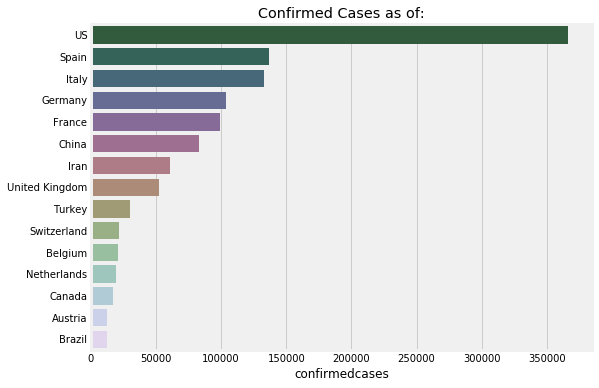

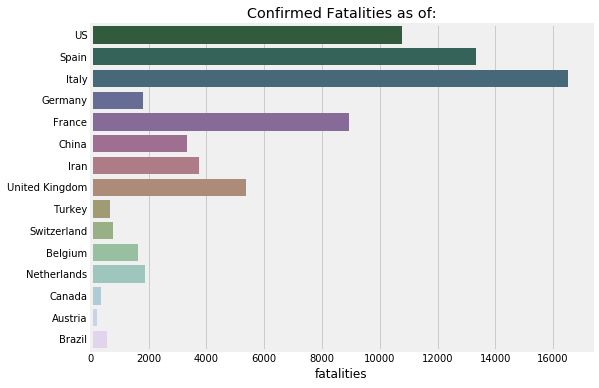

In [82]:
fig,axes = plt.subplots(figsize=(8,6))
sns.barplot(y =top.index.get_level_values(1)[0:15], x=top['confirmedcases'][0:15], palette=palette)
plt.title('Confirmed Cases as of:')
plt.ylabel('')
plt.show();

fig,axes = plt.subplots(figsize=(8,6))
sns.barplot(y =top.index.get_level_values(1)[0:15], x=top['fatalities'][0:15],palette=palette)
plt.title('Confirmed Fatalities as of:')
plt.ylabel('')
plt.show();